# Breast Cancer Machine Learning Analysis

## Problem Statement:
Evaluate the efficacy of supervised, semi-supervised, and unsupervised learning techniques in breast cancer tumor classification using Fine Needle Aspirate (FNA) nuclear cell features.

## Objective:
Design a methodical approach to differentiate between Malignant and Benign breast cancer tumors. The process will harness Monte Carlo simulations in tandem with a variety of machine learning methodologies.

## Significance:
Given the prevalence of breast cancer diagnoses globally, an early and precise classification can be pivotal for appropriate therapeutic strategies. Nevertheless, the intrinsic diversity of data poses hurdles in maintaining consistent accuracy in classifications.

## Methodology:

##### Monte Carlo Simulations:
By leveraging Monte Carlo simulations, we aim to understand the variations in data and gauge the consistency of our classifiers. This involves multiple resampling of the dataset and performance evaluation post model training on these samples.

##### Supervised Learning - Linear SVM:
Employing Linear Support Vector Machine (SVM), this supervised strategy is grounded in labeled data. For optimal results, hyperparameter tuning is carried out through a grid search.

##### Semi-Supervised Learning - Linear SVM:
With an initial foundation of labeled data, we employ an iterative approach with the Linear SVM model. In every iteration, predictions are made on the unlabeled samples nearest to the decision boundary. Post this, they are added to the training dataset, a cycle continuing till all data gets labeled.

##### Unsupervised Learning - KMeans Clustering:
KMeans clustering drives this unsupervised strategy. Since unsupervised models are devoid of true labels, these are inferred by considering the true labels of data points in proximity to the cluster centers.

## Assessment:
The models will be benchmarked against metrics including accuracy, precision, recall, F1-score, and AUC-ROC. The cumulative performance over the Monte Carlo iterations offers insights into model stability and reliability.

## Anticipated Outcome:
The ultimate goal is to identify the most consistent and high-performing model among the supervised, semi-supervised, and unsupervised techniques when coupled with Monte Carlo simulations. The findings can potentially reshape clinical diagnostics and foster enhanced patient management.

# Implementation

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn import svm
from sklearn.cluster import KMeans
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay, roc_curve, auc, precision_score, recall_score, f1_score
from sklearn.metrics.pairwise import euclidean_distances
import matplotlib.pyplot as plt

import operator
from abc import ABC, abstractmethod

import warnings
warnings.filterwarnings('ignore')

# Prior information about the data
1. Title: Wisconsin Diagnostic Breast Cancer (WDBC)

2. Number of instances: 569 

3. Number of attributes: 32 (ID, diagnosis, 30 real-valued input features)

4. Attribute information

    1) ID number
    2) Diagnosis (M = malignant, B = benign)
    3) Ten real-valued features are computed for each cell nucleus:

        a) radius (mean of distances from center to points on the perimeter)
        b) texture (standard deviation of gray-scale values)
        c) perimeter
        d) area
        e) smoothness (local variation in radius lengths)
        f) compactness (perimeter^2 / area - 1.0)
        g) concavity (severity of concave portions of the contour)
        h) concave points (number of concave portions of the contour)
        i) symmetry 
        j) fractal dimension ("coastline approximation" - 1)
        Several of the papers listed above contain detailed descriptions of how these features are computed. 

        The mean, standard error, and "worst" or largest (mean of the three largest values) of these features were computed for each image,resulting in 30 features.  For instance, field 3 is Mean Radius, field 13 is Radius SE, field 23 is Worst Radius.

        All feature values are recoded with four significant digits.

5. Missing attribute values: none

6. Class distribution: 357 benign, 212 malignant

In [2]:
# Data Loading Class
class DataLoader:
    def __init__(self, data_path, delimiter):
        # Initialize with the path of the data and its delimiter
        self.data_path = data_path
        self.delimiter = delimiter

    def load_data(self):
        # Load the data from the provided path and return as a pandas dataframe
        return pd.read_csv(self.data_path, delimiter=self.delimiter)

# Data Loading

In [3]:
# Load data and preprocess
data_loader = DataLoader("data/wdbc.data", ',')
data_frame = data_loader.load_data()

In [4]:
data_frame.shape

(569, 32)

In [5]:
data_frame.head()

,ID_number,Diagnosis,mean_radius,mean_texture,mean_parameter,mean_area,mean_smoothness,mean_compactness,mean_concavity,mean_concave_points,...,worst_radius,worst_texture,worst_parameter,worst_area,worst_smoothness,worst_compactness,worst_concavity,worst_concave_points,worst_symmetry,worst_fractal_dimension
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


# Data Exploration

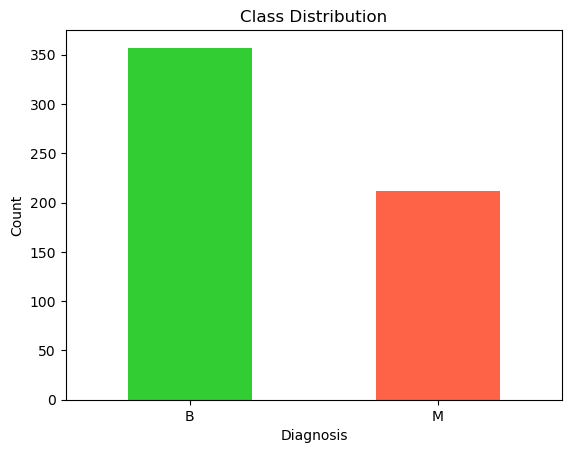

In [6]:
# Get counts of each class
class_counts = data_frame['Diagnosis'].value_counts()

# Plot
class_counts.plot(kind='bar', color=['limegreen', 'tomato'])
plt.title('Class Distribution')
plt.xlabel('Diagnosis')
plt.ylabel('Count')
plt.xticks(rotation=0)  # Keep the x-axis labels horizontal for clarity
plt.show()

In [7]:
data_frame.drop(['ID_number', 'Diagnosis'], axis=1).describe()

,mean_radius,mean_texture,mean_parameter,mean_area,mean_smoothness,mean_compactness,mean_concavity,mean_concave_points,mean_symmetry,mean_fractal_dimension,...,worst_radius,worst_texture,worst_parameter,worst_area,worst_smoothness,worst_compactness,worst_concavity,worst_concave_points,worst_symmetry,worst_fractal_dimension
count,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,...,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000
mean,14.127292,19.289649,91.969033,654.889104,0.096360,0.104341,0.088799,0.048919,0.181162,0.062798,...,16.269190,25.677223,107.261213,880.583128,0.132369,0.254265,0.272188,0.114606,0.290076,0.083946
std,3.524049,4.301036,24.298981,351.914129,0.014064,0.052813,0.079720,0.038803,0.027414,0.007060,...,4.833242,6.146258,33.602542,569.356993,0.022832,0.157336,0.208624,0.065732,0.061867,0.018061
min,6.981000,9.710000,43.790000,143.500000,0.052630,0.019380,0.000000,0.000000,0.106000,0.049960,...,7.930000,12.020000,50.410000,185.200000,0.071170,0.027290,0.000000,0.000000,0.156500,0.055040
25%,11.700000,16.170000,75.170000,420.300000,0.086370,0.064920,0.029560,0.020310,0.161900,0.057700,...,13.010000,21.080000,84.110000,515.300000,0.116600,0.147200,0.114500,0.064930,0.250400,0.071460
50%,13.370000,18.840000,86.240000,551.100000,0.095870,0.092630,0.061540,0.033500,0.179200,0.061540,...,14.970000,25.410000,97.660000,686.500000,0.131300,0.211900,0.226700,0.099930,0.282200,0.080040
75%,15.780000,21.800000,104.100000,782.700000,0.105300,0.130400,0.130700,0.074000,0.195700,0.066120,...,18.790000,29.720000,125.400000,1084.000000,0.146000,0.339100,0.382900,0.161400,0.317900,0.092080
max,28.110000,39.280000,188.500000,2501.000000,0.163400,0.345400,0.426800,0.201200,0.304000,0.097440,...,36.040000,49.540000,251.200000,4254.000000,0.222600,1.058000,1.252000,0.291000,0.663800,0.207500


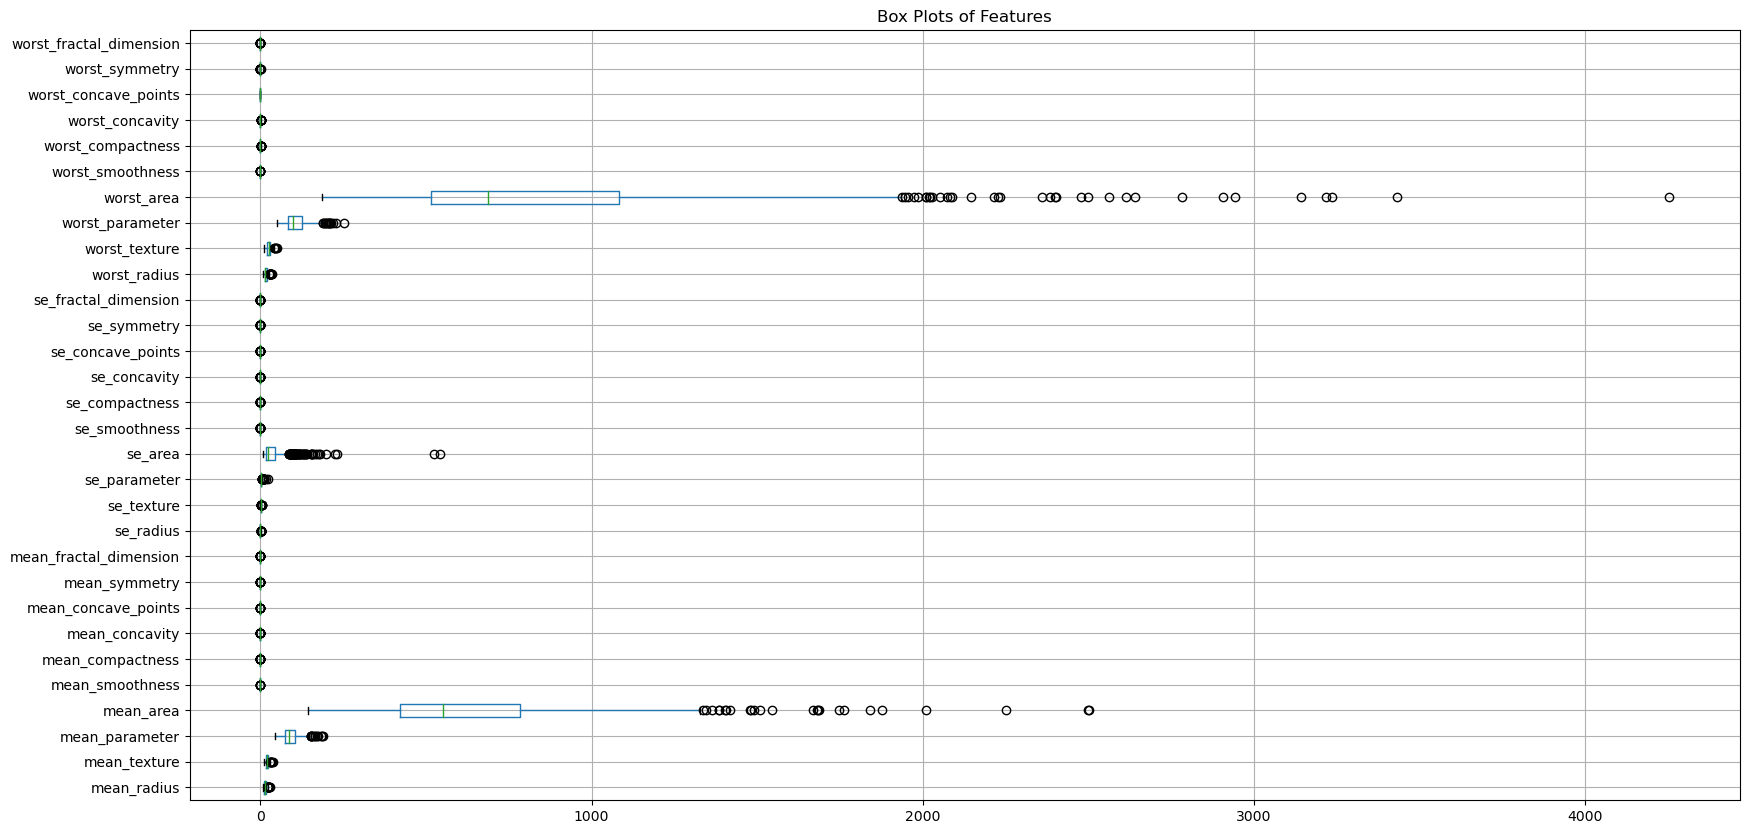

In [8]:
data_frame.drop(['ID_number', 'Diagnosis'], axis=1).boxplot(figsize=(20,10), vert=False)
plt.title('Box Plots of Features')
plt.show()

# Data Preprocessing

In [9]:
# Data Pre-processing Class
class DataPreprocessor:
    def __init__(self, data_frame):
        # Initialize with a given data frame
        self.data_frame = data_frame
        self.scaler = MinMaxScaler()

    def normalize_data(self):
        # Normalize the features (excluding ID_number and Diagnosis) using MinMaxScaler
        df = data_frame.copy()
        features = [col for col in df.columns if col not in ['ID_number', 'Diagnosis']]
        
        df[features] = self.scaler.fit_transform(df[features])
        return df.drop(['ID_number'], axis=1)
    
    def label_data(self):
        # Convert diagnosis labels from string ('M' or 'B') to integer (1 or 0)
        # Considering Malignant as Positive label, i.e M=1 
        self.data_frame["Diagnosis"] = self.data_frame["Diagnosis"].map( {'M':1,'B':0} )

In [10]:
data_preprocessor = DataPreprocessor(data_frame)
data_preprocessor.label_data()
norm_df = data_preprocessor.normalize_data()

In [11]:
norm_df.head()

,Diagnosis,mean_radius,mean_texture,mean_parameter,mean_area,mean_smoothness,mean_compactness,mean_concavity,mean_concave_points,mean_symmetry,...,worst_radius,worst_texture,worst_parameter,worst_area,worst_smoothness,worst_compactness,worst_concavity,worst_concave_points,worst_symmetry,worst_fractal_dimension
0,1,0.521037,0.022658,0.545989,0.363733,0.593753,0.792037,0.703140,0.731113,0.686364,...,0.620776,0.141525,0.668310,0.450698,0.601136,0.619292,0.568610,0.912027,0.598462,0.418864
1,1,0.643144,0.272574,0.615783,0.501591,0.289880,0.181768,0.203608,0.348757,0.379798,...,0.606901,0.303571,0.539818,0.435214,0.347553,0.154563,0.192971,0.639175,0.233590,0.222878
2,1,0.601496,0.390260,0.595743,0.449417,0.514309,0.431017,0.462512,0.635686,0.509596,...,0.556386,0.360075,0.508442,0.374508,0.483590,0.385375,0.359744,0.835052,0.403706,0.213433
3,1,0.210090,0.360839,0.233501,0.102906,0.811321,0.811361,0.565604,0.522863,0.776263,...,0.248310,0.385928,0.241347,0.094008,0.915472,0.814012,0.548642,0.884880,1.000000,0.773711
4,1,0.629893,0.156578,0.630986,0.489290,0.430351,0.347893,0.463918,0.518390,0.378283,...,0.519744,0.123934,0.506948,0.341575,0.437364,0.172415,0.319489,0.558419,0.157500,0.142595


In [12]:
# Group data based on diagnosis
df_Malignant = norm_df[norm_df['Diagnosis']== 1]
df_Benign = norm_df[norm_df['Diagnosis']== 0]

In [13]:
df_Benign.shape

(357, 31)

In [14]:
df_Malignant.shape

(212, 31)

# Modules/Classes required for the classification problem

In [15]:
# Base class for Model Training
class BaseModelTrainer:
    def __init__(self, features):
        self.features = features
        self.model = None

    @abstractmethod
    def fit(self, train_df):
        pass
    
    @abstractmethod
    def predict(self, data_frame):
        pass

In [16]:
# Class for calculating different metrics
class Metrics:
    def __init__(self, y_true, y_pred):
        # Initialize with actual labels and predicted labels
        self.y_true = y_true
        self.y_pred = y_pred

    # Methods to compute various metrics
    def accuracy(self):
        return accuracy_score(self.y_true, self.y_pred)

    def precision(self):
        return precision_score(self.y_true, self.y_pred)

    def recall(self):
        return recall_score(self.y_true, self.y_pred)

    def f1(self):
        return f1_score(self.y_true, self.y_pred)
    
    def roc(self):
        return roc_curve(self.y_true, self.y_pred)
    
    def auc(self):
        fpr, tpr, _ = self.roc()
        return auc(fpr, tpr)

In [17]:
def get_metrics(y_true, y_pred):
    # Initialize the Metrics object and compute several metrics for the provided true and predicted values.
        
    metrics = Metrics(y_true, y_pred)
    
    score = metrics.accuracy()
    precision = metrics.precision()
    recall = metrics.recall()
    f1 = metrics.f1()
    fpr, tpr, _  = metrics.roc()
    auc = metrics.auc()
    
    return [score, precision, recall, f1, fpr, tpr, auc]

In [18]:
# Class to visualize the results
class ResultsVisualizer:
    def __init__(self, info):
        # Initialize with actual and predicted labels for both training and testing
        self.train_actual, self.test_actual, self.train_pred, self.test_pred = info

    # Methods to visualize results
    def plot_confusion_matrices(self):
        # Plot confusion matrices for training and testing datasets
        
        print("\nTraining Set Confusion Matrix-")
        train_cm1 = ConfusionMatrixDisplay.from_predictions(self.train_actual, self.train_pred)
        plt.show()
        
        print("\n\nTest Set Confusion Matrix-")
        test_cm1 = ConfusionMatrixDisplay.from_predictions(self.test_actual, self.test_pred)
        plt.show()

    def plot_roc_curves(self):
        # Plot ROC curves for training and testing datasets
        
        train_fpr, train_tpr, _ = roc_curve(self.train_actual, self.train_pred)
        test_fpr, test_tpr, _ = roc_curve(self.test_actual, self.test_pred)
        
        print("\nTraining Set ROC Curve-")
        plt.figure()
        plt.plot(train_fpr, train_tpr)
        plt.plot([0, 1], [0, 1], 'g--')
        plt.xlabel('FPR')
        plt.ylabel('TPR')
        plt.show()

        print("\n\nTest Set ROC Curve-")
        plt.figure()
        plt.plot(test_fpr, test_tpr)
        plt.plot([0, 1], [0, 1], 'g--')
        plt.xlabel('FPR')
        plt.ylabel('TPR')
        plt.show()

In [19]:
def visulaize_results(last_iter_info):
    # Visualize results, including confusion matrices and ROC curves, from the last iteration
    visualizer = ResultsVisualizer(last_iter_info)
    visualizer.plot_confusion_matrices()
    visualizer.plot_roc_curves()

In [20]:
class MonteCarloSimulation:
    def __init__(self, df_Malignant, df_Benign, features, n_iterations=30):
        # Initialization method for Monte Carlo Simulation
        
        self.df_Malignant = df_Malignant  # Data for malignant diagnoses
        self.df_Benign = df_Benign        # Data for benign diagnoses
        self.features = features          # Feature columns
        self.n_iterations = n_iterations  # Number of simulations to run
        self.results = {}                 # Dictionary to store results
        self.last_iteration = {}          # Info from the last iteration
    
    @abstractmethod
    def run(self):
        # Abstract method for running the Monte Carlo simulation
        pass 

      
    def resample(self):
        # This method is responsible for resampling the data.
        # It divides the data for both benign and malignant cases into training and testing datasets.
        
        train_Malignant = self.df_Malignant.sample(frac=0.8) 
        test_Malignant = self.df_Malignant.drop(train_Malignant.index)

        train_Benign = self.df_Benign.sample(frac=0.8) 
        test_Benign = self.df_Benign.drop(train_Benign.index)

        # Concatenating the benign and malignant datasets to create the final training and testing datasets
        train_df=pd.concat([train_Malignant,train_Benign],axis=0)
        test_df=pd.concat([test_Malignant,test_Benign],axis=0)

        train_actual = train_df["Diagnosis"].to_numpy()
        test_actual = test_df["Diagnosis"].to_numpy()
        
        return train_df, test_df, train_actual, test_actual
    
    def calculate_metrics(self, train_actual, test_actual, train_pred, test_pred):
        # Calculate metrics for both training and test datasets
        
        train_metrics = get_metrics(train_actual, train_pred)
        test_metrics = get_metrics(test_actual, test_pred)
        
        return (train_metrics + test_metrics)
    
        
    def get_last_iteration_info(self):
        # Return the information from the last iteration of the simulation
        
        return self.last_iteration['info']
    
    def average_scores(self):
        # Calculate and return the average scores across all iterations of the simulation
        
        results_df = pd.DataFrame.from_dict(self.results,orient='index',
                              columns=['Accuracy_Train','Precision_Train','Recall_Train','F1_score_Train',
                                       'FPR_Train','TPR_Train','AUC_Train','Accuracy_Test','Precision_Test',
                                       'Recall_Test','F1_score_Test','FPR_Test','TPR_Test','AUC_Test'
                                      ])
        
        average_accuracy_train = results_df['Accuracy_Train'].mean()
        average_precision_train = results_df['Precision_Train'].mean()
        average_recall_train = results_df['Recall_Train'].mean()
        average_f1_score_train = results_df['F1_score_Train'].mean()
        average_AUC_train = results_df['AUC_Train'].mean()
        
        average_accuracy_test = results_df['Accuracy_Test'].mean()
        average_precision_test = results_df['Precision_Test'].mean()
        average_recall_test = results_df['Recall_Test'].mean()
        average_f1_score_test = results_df['F1_score_Test'].mean()
        average_AUC_test = results_df['AUC_Test'].mean()
        
        average_result={}
        average_result['Accuracy']=(average_accuracy_train,average_accuracy_test)
        average_result['Precision']=(average_precision_train,average_precision_test)
        average_result['Recall']=(average_recall_train,average_recall_test)
        average_result['F1_score']=(average_f1_score_train,average_f1_score_test)
        average_result['AUC']=(average_AUC_train,average_AUC_test)
        
        averages_df = pd.DataFrame.from_dict(average_result, orient='index',
                              columns=['Training Data', 'Test Data'])
        
        return averages_df


# Supervised Approach

In [21]:
class LinearSVCModelTrainer(BaseModelTrainer):
    def __init__(self, features):
        # Initialization for LinearSVCModelTrainer, inheriting from BaseModelTrainer
        super().__init__(features)

    def fit(self, train_df):
        # Training the model using a grid search over different C values
        
        Cs = np.arange(1, 12)
        params = {'C': Cs}
        
        # Use GridSearchCV to search for the best hyperparameters using 5-fold cross-validation
        self.model = GridSearchCV(cv=5, n_jobs=-1, estimator=svm.LinearSVC(penalty='l1', loss='squared_hinge', dual=False, max_iter=15000), param_grid=params)
        self.model.fit(train_df[self.features], train_df['Diagnosis'])
    
    def predict(self, data_frame):
        # Predicting class labels using the trained model
        pred = self.model.predict(data_frame[self.features])
        return pred
    
    def get_distances(self, unlabeled_df):
        # Get distances to the decision boundary for unlabeled data points
        return self.model.decision_function(unlabeled_df[self.features])
    
    def refit(self, train_df):
        # Refit the model using new training data
        self.model = self.model.fit(train_df[self.features], train_df['Diagnosis'])

In [22]:
class SupervisedMonteCarlo(MonteCarloSimulation):
    def __init__(self, df_Malignant, df_Benign, features, n_iterations=30):
        # Initialization for SupervisedMonteCarlo, inheriting from MonteCarloSimulation
        super().__init__(df_Malignant, df_Benign, features, n_iterations)
        
    def run(self):
        # Main loop to run Monte Carlo Simulation
        for run in range(1, self.n_iterations + 1):
            
            # Resample data for each iteration
            train_df, test_df, train_actual, test_actual = self.resample()
            trainer = LinearSVCModelTrainer(self.features)
            
            # Fit and predict using the trainer
            trainer.fit(train_df)
            train_pred = trainer.predict(train_df)
            test_pred = trainer.predict(test_df)
            
            # Calculate and store metrics for each iteration
            self.results[run] = self.calculate_metrics(train_actual, test_actual, train_pred, test_pred)
            
        # Store details of the last iteration separately
        self.last_iteration = {'info':(train_actual, test_actual, train_pred, test_pred)}  

In [24]:
# Monte Carlo Simulation of Supervised Learning using Linear SVM
features = [col for col in norm_df.columns if col != 'Diagnosis']

# Instantiate and run the Monte Carlo Simulation
mc_simulation = SupervisedMonteCarlo(df_Malignant, df_Benign, features, 30)
mc_simulation.run()

# Retrieve results from the last iteration and overall average scores
last_iter_info = mc_simulation.get_last_iteration_info()
average_scores_SL = mc_simulation.average_scores()

# Display average scores using some assumed display() function
display(average_scores_SL)

,Training Data,Test Data
Accuracy,0.986257,0.969027
Precision,0.991422,0.973745
Recall,0.971569,0.942857
F1_score,0.981373,0.957496
AUC,0.983278,0.963682



Training Set Confusion Matrix-


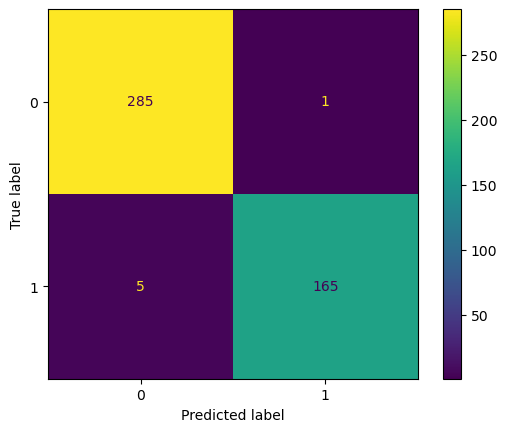



Test Set Confusion Matrix-


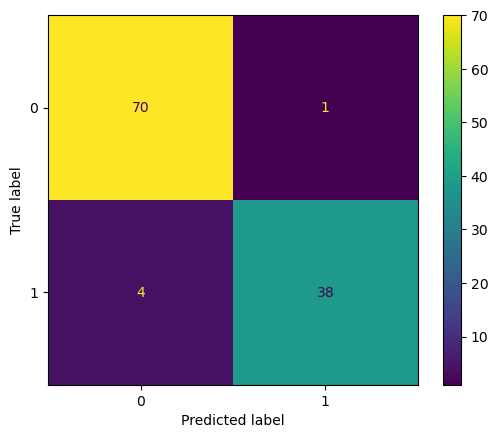


Training Set ROC Curve-


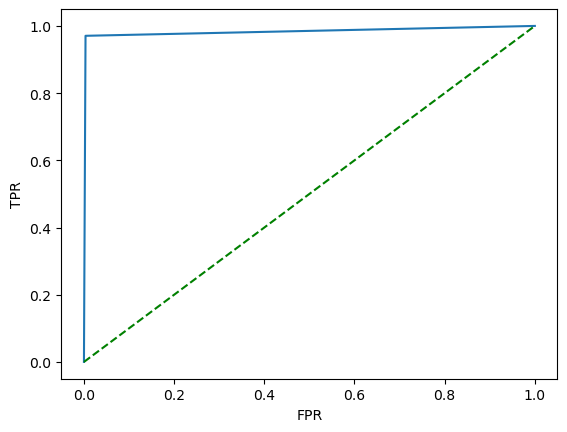



Test Set ROC Curve-


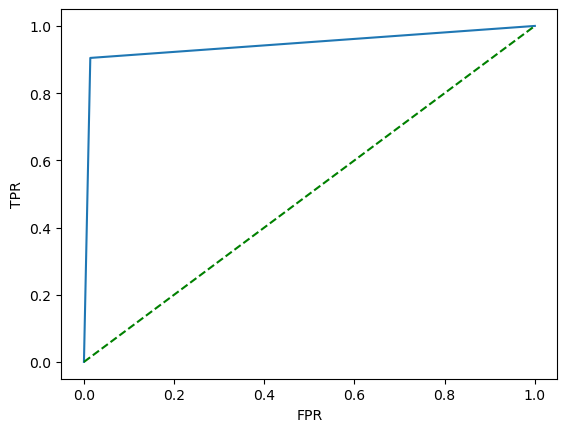

In [25]:
visulaize_results(last_iter_info)

# Semi-Supervised Approach

In [26]:
class SemiSupervisedMonteCarlo(MonteCarloSimulation):
    def __init__(self, df_Malignant, df_Benign, features, n_iterations=30):
        # Initialization for SemiSupervisedMonteCarlo, inheriting from MonteCarloSimulation
        super().__init__(df_Malignant, df_Benign, features, n_iterations)
        
    def run(self):
        # Main loop to run Monte Carlo Simulation
        for run in range(1, self.n_iterations + 1):
            
            # Resample to get labeled, unlabeled, train, and test datasets
            labeled_df, unlabeled_df, train_df, test_df, train_actual, test_actual = self.resample()
            trainer = LinearSVCModelTrainer(self.features)
            
            # Initial training using labeled data
            trainer.fit(labeled_df)
            
            batch_size = 20
            
            # Iteratively add most uncertain samples to labeled set and retrain
            for k in range(0, len(unlabeled_df[self.features]), batch_size):
                distances = trainer.get_distances(unlabeled_df)

                # Get the indices of the samples furthest from the decision boundary
                max_dist_indices = np.argsort(np.abs(distances))[-batch_size:]

                # Extract batch of uncertain samples
                batch_data = unlabeled_df.iloc[max_dist_indices]

                # Predict their labels
                pred_batch = trainer.predict(pd.DataFrame(batch_data[self.features]))

                # Create DataFrame with predicted labels
                pred_batch_df = pd.DataFrame(pred_batch, columns=['Diagnosis'])
                pred_batch_df.set_index(batch_data.index, inplace=True)    

                # Combine features and predicted labels
                labeled_batch = pd.merge(batch_data[self.features], pred_batch_df, left_index=True, right_index=True)

                # Add them to labeled data
                labeled_df = pd.concat([labeled_df, labeled_batch])

                # Remove the labeled samples from the unlabeled set
                unlabeled_df = unlabeled_df.drop(batch_data.index)

                # Refit the model with new labeled data
                trainer.refit(labeled_df)
            
            # Prediction using the trained model
            train_pred = trainer.predict(train_df[self.features])
            test_pred = trainer.predict(test_df[self.features])
            
            # Calculate and store metrics for each iteration
            self.results[run] = self.calculate_metrics(train_actual, test_actual, train_pred, test_pred)
        
        # Store details of the last iteration separately
        self.last_iteration = {'info':(train_actual, test_actual, train_pred, test_pred)}  
    
    def resample(self):
        # Resample to split data into train and test sets
        train_df, test_df, train_actual, test_actual = super(SemiSupervisedMonteCarlo, self).resample()
        
        # Separating data based on diagnosis
        train_Malignant = train_df[norm_df['Diagnosis']== 1]
        train_Benign = train_df[norm_df['Diagnosis']== 0]
        
        # Divide training set into labeled and unlabeled subsets
        labeled_df_Malignant = train_Malignant.sample(frac=0.5) 
        unlabeled_df_Malignant = train_Malignant.drop(labeled_df_Malignant.index)

        labeled_df_Benign = train_Benign.sample(frac=0.5) 
        unlabeled_df_Benign = train_Benign.drop(labeled_df_Benign.index)

        # Combining labeled and unlabeled samples from both classes
        labeled_df=pd.concat([labeled_df_Malignant,labeled_df_Benign],axis=0)
        unlabeled_df=pd.concat([unlabeled_df_Malignant,unlabeled_df_Benign],axis=0)
        
        return labeled_df, unlabeled_df, train_df, test_df, train_actual, test_actual

In [27]:
# Monte Carlo Simulation of Semi-Supervised Learning using Linear SVM
# Instantiate and run the Monte Carlo Simulation
mc_simulation = SemiSupervisedMonteCarlo(df_Malignant, df_Benign, features, 30)
mc_simulation.run()

# Retrieve results from the last iteration and overall average scores
last_iter_info = mc_simulation.get_last_iteration_info()
average_scores_SSL = mc_simulation.average_scores()

# Display average scores using some assumed display() function
display(average_scores_SSL)

,Training Data,Test Data
Accuracy,0.978070,0.964602
Precision,1.000000,1.000000
Recall,0.941176,0.904762
F1_score,0.969697,0.950000
AUC,0.970588,0.952381



Training Set Confusion Matrix-


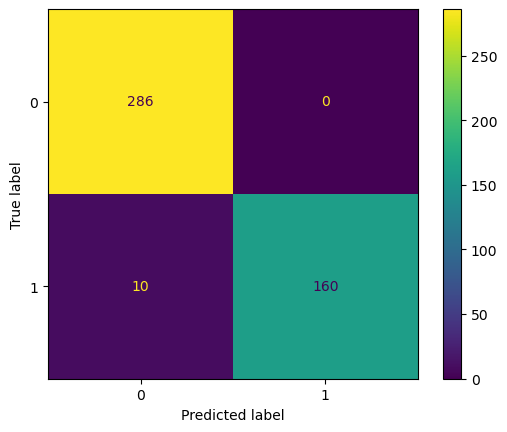



Test Set Confusion Matrix-


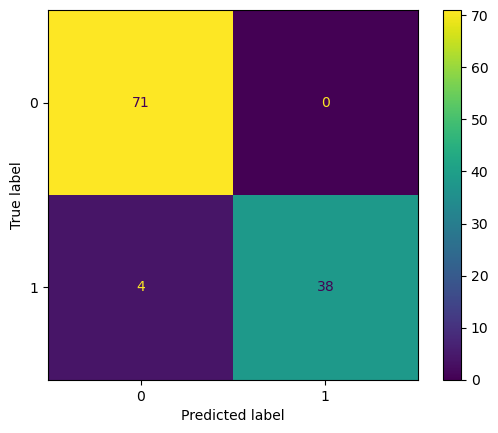


Training Set ROC Curve-


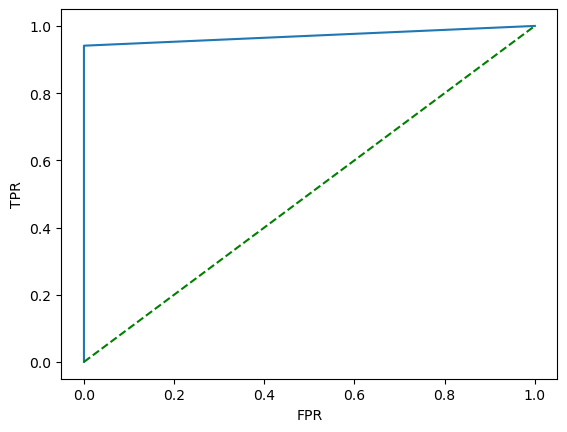



Test Set ROC Curve-


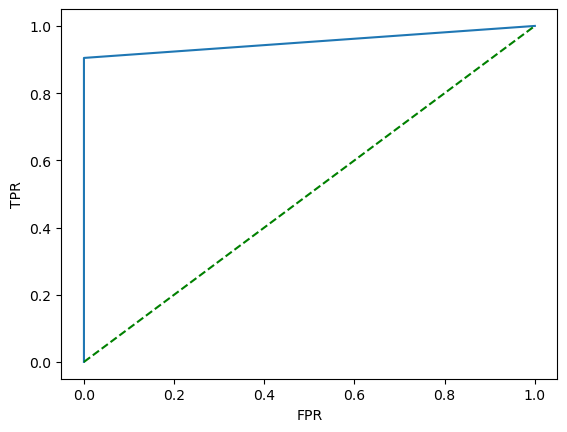

In [28]:
visulaize_results(last_iter_info)

# Unsupervised Approach

In [29]:
class KMeansModelTrainer(BaseModelTrainer):
    def __init__(self, features):
        super().__init__(features)
        self.cluster_labels = {}

    def fit(self, train_df):
        self.model = KMeans(n_clusters=2, init='random',n_init=20)
        self.model = self.model.fit(train_df[self.features])
    
    def infer_cluster_labels(self, data, true_labels, top_n=30):
        cluster_center = self.model.cluster_centers_
        distances = euclidean_distances(data[self.features], cluster_center)
        cluster_data = [{i: distances[i][j] for i in range(len(data))} for j in range(self.model.n_clusters)]
        
        # Sort and get the top_n points for each cluster
        for idx, cluster in enumerate(cluster_data):
            sorted_cluster = sorted(cluster.items(), key=operator.itemgetter(1))
            label_count = {}
            
            for i in range(top_n):
                point_idx = sorted_cluster[i][0]
                label = true_labels[point_idx]
                label_count[label] = label_count.get(label, 0) + 1
            
            # Get the most frequent label for the cluster
            sorted_labels = sorted(label_count.items(), key=operator.itemgetter(1), reverse=True)
            self.cluster_labels[idx] = sorted_labels[0][0]
            
    def predict(self, data):
        pred = self.model.predict(data[self.features])
        return [self.cluster_labels[p] for p in pred]

In [30]:
class UnsupervisedMonteCarlo(MonteCarloSimulation):
    def __init__(self, df_Malignant, df_Benign, features, n_iterations=30):
        # Initialize UnsupervisedMonteCarlo inheriting from MonteCarloSimulation
        super().__init__(df_Malignant, df_Benign, features, n_iterations)
        
    def run(self):
        # Main loop to run Monte Carlo Simulation
        for run in range(1, self.n_iterations + 1):
            
            # Resample data for each iteration
            train_df, test_df, train_actual, test_actual = self.resample()
            trainer = KMeansModelTrainer(self.features)
            
            # Train KMeans model on resampled training data
            trainer.fit(train_df)
            
            # Infer actual labels for each cluster
            trainer.infer_cluster_labels(train_df, train_actual)
            
            # Predict labels for train and test sets
            train_pred = trainer.predict(train_df)
            test_pred = trainer.predict(test_df)
            
            # Calculate and store performance metrics for each iteration
            self.results[run] = self.calculate_metrics(train_actual, test_actual, train_pred, test_pred)
        
        # Store details of the last iteration separately
        self.last_iteration = {'info':(train_actual, test_actual, train_pred, test_pred)}  

In [31]:
# Monte Carlo Simulation of Unsupervised Learning using Linear SVM
# Instantiate and run the Monte Carlo Simulation
mc_simulation = UnsupervisedMonteCarlo(df_Malignant, df_Benign, features, 30)
mc_simulation.run()

# Retrieve results from the last iteration and overall average scores
last_iter_info = mc_simulation.get_last_iteration_info()
average_scores_UL = mc_simulation.average_scores()

# Display average scores using some assumed display() function
display(average_scores_UL)

,Training Data,Test Data
Accuracy,0.927558,0.926844
Precision,0.949430,0.960313
Recall,0.851176,0.838095
F1_score,0.897533,0.894323
AUC,0.912068,0.908719



Training Set Confusion Matrix-


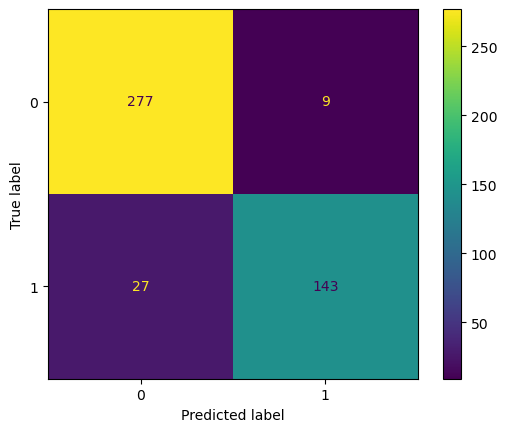



Test Set Confusion Matrix-


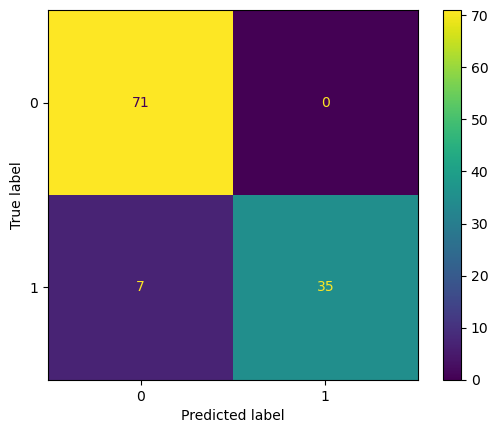


Training Set ROC Curve-


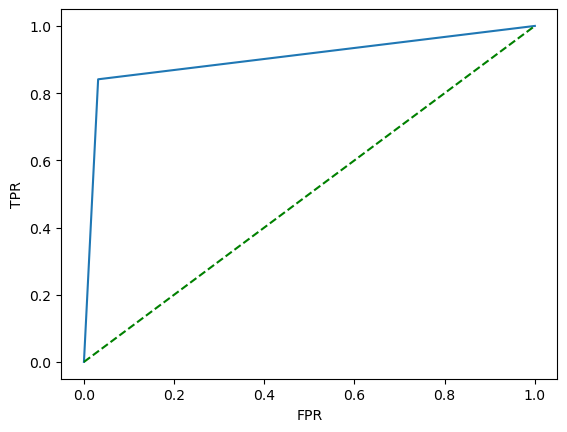



Test Set ROC Curve-


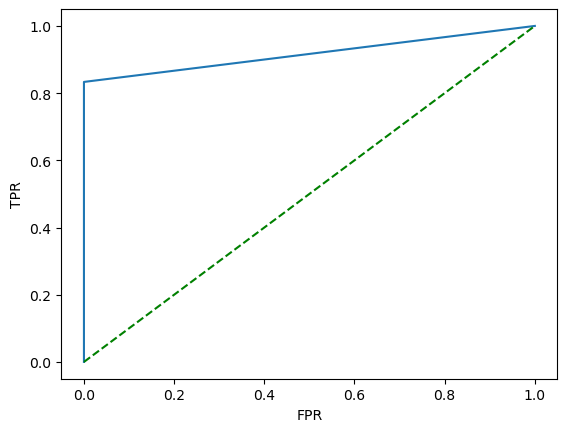

In [32]:
visulaize_results(last_iter_info)

In [38]:
print("Supervised Learning Perfomance")
display(average_scores_SL)
print("Semi-Supervised Learning Perfomance")
display(average_scores_SSL)
print("Unsupervised Learning Perfomance")
display(average_scores_UL)

Supervised Learning Perfomance


,Training Data,Test Data
Accuracy,0.986257,0.969027
Precision,0.991422,0.973745
Recall,0.971569,0.942857
F1_score,0.981373,0.957496
AUC,0.983278,0.963682


Semi-Supervised Learning Perfomance


,Training Data,Test Data
Accuracy,0.978070,0.964602
Precision,1.000000,1.000000
Recall,0.941176,0.904762
F1_score,0.969697,0.950000
AUC,0.970588,0.952381


Unsupervised Learning Perfomance


,Training Data,Test Data
Accuracy,0.927558,0.926844
Precision,0.949430,0.960313
Recall,0.851176,0.838095
F1_score,0.897533,0.894323
AUC,0.912068,0.908719
